In [1]:
pip install  --quiet lightning-bolts

Note: you may need to restart the kernel to use updated packages.


In [3]:
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

/root/.local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/root/.local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapC

In [4]:
from torchvision import datasets, transforms
import pytorch_lightning as pl
import torch

transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

class MNISTtoRGB(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(MNISTtoRGB, self).__init__(root, train, transform, target_transform, download)

    def __getitem__(self, index):
        img, target = super(MNISTtoRGB, self).__getitem__(index)
        img = torch.cat((img, img, img), 0)  # Convert single channel to 3 channels (R, G, B)
    
        return img, target
    
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, num_workers):
        super().__init__()       
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        pass 

    def setup(self,stage=None):
        self.train_ds = MNISTtoRGB(
            root=self.data_dir, 
            train=True, 
            transform=transform, 
            download=True
        )

        self.test_ds = MNISTtoRGB(
            root=self.data_dir, 
            train=False, 
            transform=transform
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

In [6]:
data_dir = "."
batch_size = 512
num_workers = 6
mnist_dm =  MNISTDataModule(
    data_dir=data_dir,
    batch_size=batch_size,
    num_workers=num_workers)

In [7]:
mnist_dm.prepare_data()
mnist_dm.setup()

In [60]:
!pip install fastcore

In [8]:
import fastcore.all as fc

In [9]:
import numpy as np

In [10]:
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if noframe: ax.axis('off')
    return ax

In [11]:
encoder = resnet18_encoder(False, False)

/tmp/ipykernel_673/489695083.py:1: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  encoder = resnet18_encoder(False, False)
/root/.local/lib/python3.9/site-packages/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
/root/.local/lib/python3.9/site-packages/pl_bolts/models/autoencoders/components.py:236: UnderRevie

In [12]:
import torch
import torch.nn as nn
encoder.conv1 = nn.Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [13]:
encoder.conv1

Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [14]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import OneCycleLR

class VAELitModel_mnist(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()
        self.train_loss = []

        # encoder, decoder
        self.encoder = encoder
        self.decoder = resnet18_decoder(
            latent_dim=256,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

        #label embedding
        #self.label_embedding  = nn.Embedding(num_embed, embedding_dim=enc_out_dim)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)

        self.scheduler = OneCycleLR(
            optimizer,
            max_lr=1e-3,
            steps_per_epoch=len(self.trainer.datamodule.train_dataloader()),
            epochs=self.trainer.max_epochs,
            pct_start=5/self.trainer.max_epochs,
            three_phase=True,
            div_factor=10,
            final_div_factor=10,
            anneal_strategy='linear',
        )

        return {
          "optimizer": optimizer,
          "lr_scheduler": {
            "scheduler": self.scheduler ,
            "interval": "step",
          }
        }

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def forward(self, x):
        x, label = x
        label = F.one_hot(label,num_classes=32)
        label = label.unsqueeze(1).repeat(1, 32, 1)
        label = label.unsqueeze(1)
        x_encoded_embedded = torch.cat((x,label),dim=1)
        x_encoded = self.encoder(x_encoded_embedded)


        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)
        return x_hat

    def training_step(self, batch, batch_idx):
        x, label = batch
        label = F.one_hot(label,num_classes=32)
        label_channel = label.unsqueeze(1).repeat(1, 32, 1)
        label_channel = label_channel.unsqueeze(1)
        x_encoded_embedded = torch.cat((x,label_channel),dim=1)
        # encode x to get the mu and variance parameters
        x_encoded_embedded = self.encoder(x_encoded_embedded)

        mu, log_var = self.fc_mu(x_encoded_embedded), self.fc_var(x_encoded_embedded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict(
            {
                "elbo": elbo,
                "kl": kl.mean(),
                "recon_loss": recon_loss.mean(),
                "reconstruction": recon_loss.mean(),
            }
        )

        self.train_loss.append(elbo)
        return elbo

    def on_train_epoch_end(self):
        mean_loss = sum(self.train_loss) / len(self.train_loss)
        print(f"Epoch: {self.current_epoch+1} | Loss: {mean_loss}")
        self.train_loss = []

In [16]:
pl.seed_everything(1234)

vae = VAELitModel_mnist()
trainer = pl.Trainer(gpus=1, max_epochs=30, enable_progress_bar=True)
trainer.fit(vae, mnist_dm)

Global seed set to 1234
/tmp/ipykernel_673/627645724.py:16: UnderReviewWarning: The feature resnet18_decoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.decoder = resnet18_decoder(
/root/.local/lib/python3.9/site-packages/pl_bolts/models/autoencoders/components.py:339: UnderReviewWarning: The feature ResNetDecoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetDecoder(DecoderBlock, [2, 2, 2, 2], latent_dim, input_height, first_conv, maxpool1)
/root/.local/lib/python3.9/site-packages/pl_bolts/models

Training: 0it [00:00, ?it/s]

Epoch: 1 | Loss: 3350.240234375
Epoch: 2 | Loss: 2975.52099609375
Epoch: 3 | Loss: 2754.182373046875
Epoch: 4 | Loss: 2501.49853515625
Epoch: 5 | Loss: 2216.71337890625
Epoch: 6 | Loss: 1858.8548583984375
Epoch: 7 | Loss: 1546.24755859375
Epoch: 8 | Loss: 1310.2340087890625
Epoch: 9 | Loss: 1128.534912109375
Epoch: 10 | Loss: 1013.621337890625
Epoch: 11 | Loss: 954.6358642578125
Epoch: 12 | Loss: 923.4208984375
Epoch: 13 | Loss: 887.4007568359375
Epoch: 14 | Loss: 854.9122924804688
Epoch: 15 | Loss: 823.2014770507812
Epoch: 16 | Loss: 795.0640258789062
Epoch: 17 | Loss: 767.3536987304688
Epoch: 18 | Loss: 743.2490844726562
Epoch: 19 | Loss: 721.6187133789062
Epoch: 20 | Loss: 700.5624389648438
Epoch: 21 | Loss: 678.3116455078125
Epoch: 22 | Loss: 658.6866455078125
Epoch: 23 | Loss: 641.5447387695312
Epoch: 24 | Loss: 626.4949951171875
Epoch: 25 | Loss: 611.6993408203125
Epoch: 26 | Loss: 600.0975341796875
Epoch: 27 | Loss: 588.6013793945312
Epoch: 28 | Loss: 577.947998046875
Epoch: 29 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch: 30 | Loss: 564.4158325195312


In [18]:
ref_img,ref_label =mnist_dm.test_ds[10]
img = ref_img
print(f"ref_label: {ref_label}")

ref_label: 0


In [19]:

import torch
import numpy as np
import matplotlib.pyplot as plt

In [20]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid

In [22]:
mean,std = (0.1307,), (0.3081,)
mean1, std1 = np.array(mean), np.array(std)
ref_img= make_grid(ref_img).permute(1, 2, 0).numpy() * std1 + mean1



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

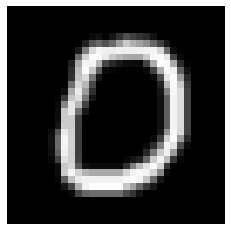

In [23]:
show_image(ref_img)

In [26]:
wrong_label = torch.tensor([9])
pred = img.unsqueeze(0)
pred.shape,wrong_label

(torch.Size([1, 3, 32, 32]), tensor([9]))

In [212]:
clean_mem()

In [110]:
def vae_preds(pred,wrong_label):
    with torch.no_grad():
        for _ in range(150):
                label = F.one_hot(wrong_label,num_classes=32)
                label = label.unsqueeze(0).repeat(32,1)
                label = label.unsqueeze(0)
                x_encoded_embedded = torch.cat((pred.squeeze(),label),dim=0)
                x_encoded = vae.encoder(x_encoded_embedded.unsqueeze(0))


                mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)

                # sample z from q
                std = torch.exp(log_var / 2)
                q = torch.distributions.Normal(mu, std)
                z = q.rsample()

                # decoded
                pred = vae.decoder(z)
        return pred.squeeze()

In [111]:
val_dl = mnist_dm.val_dataloader()

In [112]:
xbs,labels = next(iter(val_dl))
xbs,labels = xbs[:25],labels[:25]

In [113]:
wrong_labels = (labels + 1) % 10

In [114]:
wrong_labels,labels

(tensor([8, 3, 2, 1, 5, 2, 5, 0, 6, 0, 1, 7, 0, 1, 2, 6, 0, 8, 4, 5, 0, 7, 7, 6,
         5]),
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
         4]))

In [115]:
xbs = xbs.to(vae.device)
wrong_labels = wrong_labels.to(vae.device)

In [116]:
preds = list(map(lambda x: vae_preds(x[0],x[1]),zip(xbs,wrong_labels)))

In [117]:

mean, std = torch.tensor(mean), torch.tensor(std)
mean.shape,std.shape


/tmp/ipykernel_673/1227271918.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, std = torch.tensor(mean), torch.tensor(std)


(torch.Size([1]), torch.Size([1]))

In [118]:
unnormalized_preds = list(map( lambda x : x * std + mean,preds))

In [119]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Original Label: 7 
Input Label: 8
Original Label: 2 
Input Label: 3
Original Label: 1 
Input Label: 2
Original Label: 0 
Input Label: 1
Original Label: 4 
Input Label: 5
Original Label: 1 
Input Label: 2
Original Label: 4 
Input Label: 5
Original Label: 9 
Input Label: 0
Original Label: 5 
Input Label: 6
Original Label: 9 
Input Label: 0
Original Label: 0 
Input Label: 1
Original Label: 6 
Input Label: 7
Original Label: 9 
Input Label: 0
Original Label: 0 
Input Label: 1
Original Label: 1 
Input Label: 2
Original Label: 5 
Input Label: 6
Original Label: 9 
Input Label: 0
Original Label: 7 
Input Label: 8
Original Label: 3 
Input Label: 4
Original Label: 4 
Input Label: 5
Original Label: 9 
Input Label: 0
Original Label: 6 
Input Label: 7
Original Label: 6 
Input Label: 7
Original Label: 5 
Input Label: 6
Original Label: 4 
Input Label: 5


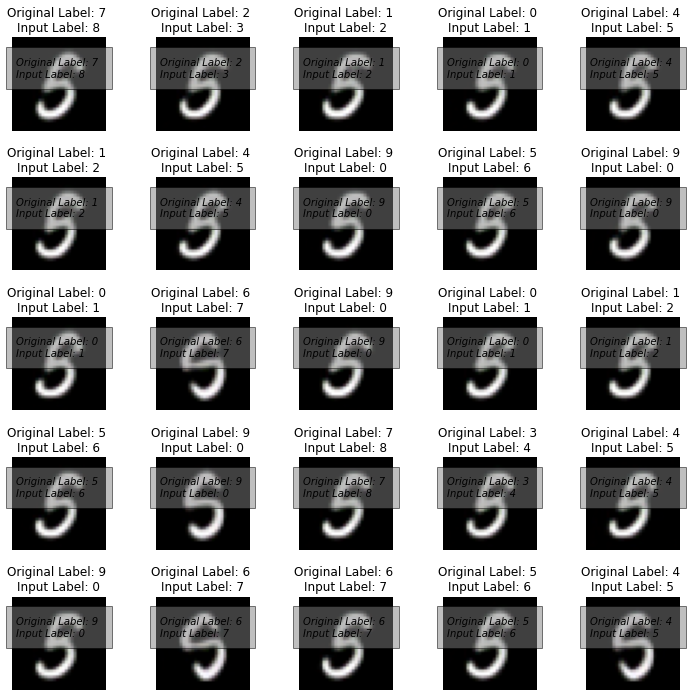

<Figure size 432x288 with 0 Axes>

In [120]:
fig,axs = plt.subplots(5,5,figsize=(12,12))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for ax,img,label,wrong_label in zip(axs.flat,unnormalized_preds,labels,wrong_labels):
    label_text = f"Original Label: {classes[label.item()]} \n"
    label_text += f"Input Label: {classes[wrong_label.item()]}"
    print(label_text)
    ax = show_image(img,ax,title=label_text)
    ax.text(1, 13, label_text, style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
    #ax.text(0, 1.0, label_text, fontsize=8)
plt.show()
plt.savefig('./mnist_cvae.png')

In [247]:
preds[0].shape


torch.Size([3, 32, 32])

In [67]:
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

# %% ../nbs/11_initializing.ipynb 12
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

# %% ../nbs/11_initializing.ipynb 13
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [66]:
import sys,gc,traceback
import fastcore.all as fc

In [68]:
clean_mem()